# 💻 Geopandas: en introduksjon

I denne seksjonen vil vi dekke det grunnleggende med *geopandas*, et Python-bibliotek for
å samhandle med romlig vektordata.

[Geopandas](https://geopandas.org/) gir et brukervennlig grensesnitt til vektordatasett. Det kombinerer mulighetene til *pandas*
med geometrikapabilitetene til
[shapely](#02_geometriske_objekter), [romlig-filformateringstøtte
fra fiona](#03_vektor) og kartprojeksjonsbibliotekene til
pyproj(som vi ser på neste uke).

Hoveddatastrukturene i geopandas er `GeoDataFrame`s og `GeoSeries`. De
utvider funksjonaliteten til `pandas.DataFrame`s og `pandas.Series`.

Det er en nøkkelforskjell mellom pandas dataframes og geopandas
[`GeoDataFrame`s](https://geopandas.org/en/stable/docs/user_guide/data_structures.html#geodataframe):
en `GeoDataFrame` inneholder en ekstra kolonne for geometrier. Som standard er
navnet på denne kolonnen `geometry`, og det er en
[`GeoSeries`](https://geopandas.org/en/stable/docs/user_guide/data_structures.html#geoseries)
som inneholder geometrier (punkter, linjer, polygoner, ...) som
`shapely.geometry` objekter.

In [1]:
import pathlib
import geopandas
import numpy

DATA_MAPPE = pathlib.Path().resolve() / "data"

HIGHLIGHT_STYLE = "background: #f66161;"

# så følgende blokk er litt dårlig magi for å få tabellutdataen til å se
# fin ut (denne cellen er skjult, vi er bare interessert i en kort tabellisting
# der geometrikolonnen er fremhevet).
#
# For dette, vi
#    1. konverterer geopandas tilbake til en ‘normal’ pandas.DataFrame med en forkortet
#       WKT-streng i geometrikolonnen
#    1b. samtidig som vi gjør det, blir vi kvitt de fleste av kolonnene (gir de gjenværende kolonner nye navn)
#    2. bruker stilen på alle celler i kolonnen "geometry", og til aksen-1-indeksen "geometry"

# Hvorfor gikk jeg via en ‘plain’ `pandas.DataFrame`?
# `pandas.set_option("display.max_colwidth", 40)` ble ignorert, så dette så ut som den reneste måten

df = geopandas.read_file(DATA_MAPPE / "arealdekke" / "ArealdekkeN50.gpkg")

df["geom"] = df.geometry.to_wkt().apply(lambda wkt: wkt[:40] + " ...")

df = df[["klasse", "klasse_navn", "geometry"]]

(
    df.head().style
        .map(lambda x: HIGHLIGHT_STYLE, subset=["geometry"])
        .apply_index(lambda x: numpy.where(x.isin(["geometry"]), HIGHLIGHT_STYLE, ""), axis=1)
)

,klasse,klasse_navn,geometry
0,100,myr,"POLYGON ((265791.9 6614994.65, 265790.18 6614997.81, 265754.58 6614993.01, 265738.37 6614991.46, 265714.54 6614994.62, 265703.4 6614982.57, 265700.51 6614972.78, 265701.87 6614965.64, 265710.39 6614959.84, 265729.32 6614969.17, 265751.33 6614968.19, 265785.92 6614984.13, 265791.9 6614994.65))"
1,100,myr,"POLYGON ((262206.27 6628558.13, 262202.64 6628562.47, 262192.59 6628562.38, 262186.79 6628553.87, 262184.71 6628541.99, 262186.07 6628534.84, 262203.19 6628524.25, 262221.22 6628523.61, 262226.47 6628526.15, 262228.92 6628530.96, 262206.27 6628558.13))"
2,100,myr,"POLYGON ((265299.88 6621504.12, 265294.08 6621506.65, 265285.92 6621505.38, 265279.41 6621499.96, 265258.39 6621467.69, 265255.05 6621452.93, 265249.89 6621440.33, 265246.07 6621431.63, 265248.72 6621416.33, 265254.7 6621404.73, 265266.02 6621407.73, 265282.23 6621420.33, 265283.68 6621436.27, 265279.24 6621453.75, 265279.41 6621466.79, 265286.29 6621476.22, 265302.59 6621489.81, 265305.31 6621497.61, 265299.88 6621504.12))"
3,100,myr,"POLYGON ((260561.58 6622897.2, 260562.11 6622914.23, 260560.03 6622913.41, 260555.41 6622906.79, 260551.79 6622889.04, 260553.52 6622874.82, 260562.58 6622841.85, 260572.46 6622817.84, 260581.88 6622810.96, 260603.45 6622805, 260613.4 6622804.08, 260626.36 6622813.96, 260637.86 6622830, 260651.81 6622839.79, 260662.32 6622844.86, 260672.83 6622849.93, 260691.12 6622852.29, 260710.15 6622851.57, 260715.5 6622855.1, 260718.3 6622863.9, 260720.38 6622875.76, 260713.04 6622883.47, 260712.95 6622882.47, 260702.9 6622871.32, 260697.74 6622869.79, 260683.87 6622872.05, 260673.73 6622882.01, 260663.04 6622885.97, 260655.06 6622886.72, 260650.9 6622885.08, 260645.64 6622882.54, 260641.93 6622874.84, 260641.66 6622872.98, 260639.31 6622856.99, 260631.88 6622852.64, 260608.05 6622855.81, 260597.37 6622859.79, 260574.8 6622876.91, 260563.12 6622892.03, 260561.58 6622897.2))"
4,100,myr,"POLYGON ((265326.09 6621350.04, 265320.02 6621360.63, 265307.79 6621358.73, 265288.32 6621343.42, 265278.98 6621340.24, 265271.83 6621338.88, 265275.28 6621321.49, 265286.71 6621292.32, 265293.23 6621286.71, 265302.11 6621284.91, 265312.25 6621285.99, 265317.59 6621289.52, 265320.22 6621296.33, 265319.4 6621331.55, 265326.09 6621350.04))"


---

## Inputdata: Arealdekke over Ås kommune

I denne notebooken skal vi jobbe med et modifisert datasett fra [Kartverkets N50-serie](https://www.kartverket.no/api-og-data/kartgrunnlag-fastlands-norge).

Til denne notebooken har vi lastet ned Arealdekke-data og endret det noe for å passe til formålet for denne timen. Dataene er lastet ned fra [Geonorge](https://kartkatalog.geonorge.no/metadata/n50-kartdata/ea192681-d039-42ec-b1bc-f3ce04c189ac). Filen vi skal jobbe med ligger i `data/ArealdekkeN50.gpkg`.

---

## Les og utforsk romlig datasett

Før vi prøver å laste inn noen filer, la oss ikke glemme å definere en konstant
som peker til vår datamappe:

In [2]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_MAPPE = NOTEBOOK_PATH / "data"

I denne notebooken skal vi fokusere på arealdekke-klasser

**Målet vårt i denne notebooken er å lagre alle arealdekke-klassene i separate filer**.

*Arealdekke-klasser i den datasettet:*

|  Klasse | Navn på klasse   
|----------------|-----------
| 100          | myr
| 110          | steinbrudd
| 120          | tettbebyggelse
| 200          | innsjø
| 300          | indstriområde
| 400          | havflate
| 500          | gravplass
| 600          | dyrket mark
| 700          | åpent område
| 800          | skog
| 900          | sportidrettplass

:::{admonition} Søk etter filer ved hjelp av et mønster
:class: hint


In [3]:
input_filename = DATA_MAPPE / "arealdekke" / "ArealdekkeN50.gpkg"
data = geopandas.read_file(input_filename)

Først, sjekk datatype av det leste datasettet:

In [4]:
type(data)

geopandas.geodataframe.GeoDataFrame

Alt gikk bra, og vi har en `geopandas.GeoDataFrame`. 
La oss også utforske dataene: (1) skriv ut de første få radene, og 
(2) list opp kolonnene.

In [5]:
data.head()

,gml_id,oppdateringsdato,klasse,klasse_navn,geometry
0,idd51cad71-d02b-4043-833b-8a6e50539af0,2016-12-02,100,myr,"POLYGON ((265791.900 6614994.650, 265790.180 6..."
1,id41c8ac6e-b5ce-4657-958c-312c27dafd9a,2016-12-02,100,myr,"POLYGON ((262206.270 6628558.130, 262202.640 6..."
2,ide574839d-8f33-4b1e-bc44-01a865a1beb9,2016-12-02,100,myr,"POLYGON ((265299.880 6621504.120, 265294.080 6..."
3,id2aa8beeb-8a23-4159-ae85-d218ead88c9f,2016-12-02,100,myr,"POLYGON ((260561.580 6622897.200, 260562.110 6..."
4,iddf0f9506-8358-49ae-bd65-b496cd4571be,2016-12-02,100,myr,"POLYGON ((265326.090 6621350.040, 265320.020 6..."


In [6]:
data.columns

Index(['gml_id', 'oppdateringsdato', 'klasse', 'klasse_navn', 'geometry'], dtype='object')

Dette datasettet har flere kolonner enn vi trenger, la oss gjøre et utvalg av de vi trenger. Vi beholder 'klasse’ og ’klassenavn’, og selvfølgelig kolonnen `geometry`.

In [7]:
data = data[["klasse", "klasse_navn", "geometry"]]

Hvordan ser datasettet ut nå?

In [8]:
data.head()

,klasse,klasse_navn,geometry
0,100,myr,"POLYGON ((265791.900 6614994.650, 265790.180 6..."
1,100,myr,"POLYGON ((262206.270 6628558.130, 262202.640 6..."
2,100,myr,"POLYGON ((265299.880 6621504.120, 265294.080 6..."
3,100,myr,"POLYGON ((260561.580 6622897.200, 260562.110 6..."
4,100,myr,"POLYGON ((265326.090 6621350.040, 265320.020 6..."


```{admonition} Sjekk din forståelse:
:class: hint

Bruk dine pandas ferdigheter på dette geopandas datasettet for å finne ut følgende
informasjon:

- Hvor mange rader har datasettet?
- Hvor mange unike klasser?
```




---

### Utforsk datasettet på et kart:

Som geografer, elsker vi kart. Men utover det, er det alltid en god idé å
utforske et nytt datasett også på et kart. For å lage et enkelt kart av en
`geopandas.GeoDataFrame`, bruk ganske enkelt dens `plot()` metode. Den fungerer likt som
i pandas, men **tegner et kart basert på geometriene i datasettet** i stedet for et diagram.

<Axes: >

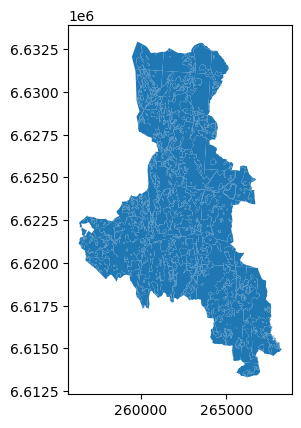

In [9]:
data.plot()

Voilá! Det er faktisk så enkelt å lage et kart ut av et geografisk datasett.
Geopandas posisjonerer automatisk kartet ditt på en måte som dekker hele
utstrekningen av dataene dine.

### Geometrier i geopandas

Geopandas drar nytte av shapelys geometriobjekter. Geometrier lagres
i en kolonne kalt *geometry*.

La oss skrive ut de første 5 radene av kolonnen `geometry`:

In [10]:
data.geometry.head()

0    POLYGON ((265791.900 6614994.650, 265790.180 6...
1    POLYGON ((262206.270 6628558.130, 262202.640 6...
2    POLYGON ((265299.880 6621504.120, 265294.080 6...
3    POLYGON ((260561.580 6622897.200, 260562.110 6...
4    POLYGON ((265326.090 6621350.040, 265320.020 6...
Name: geometry, dtype: geometry

Kolonnen `geometry` inneholder kjente verdier:
*Well-Known Text* (WKT) strenger. La deg ikke lure, de er faktisk,
`shapely.geometry` objekter (du husker de kanskje fra [forrige uke](#02_geometriske_objekter)) som når man bruke `print()` eller konverterer til
en `str`, blir representert som en WKT-streng).

Siden geometriene i en `GeoDataFrame` er lagret som shapely-objekter, kan vi
bruke **shapely metoder** for å håndtere geometrier i geopandas.

La oss ta en nærmere titt på (en av) polygon-geometriene i datasettet,
og prøve å bruke noe av shapely-funksjonaliteten vi allerede er kjent med. For enkelhetens skyld, jobber vi først med geometrien til bare den aller første linjen:

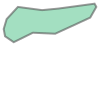

In [11]:
# Verdien av kolonnen `geometry` i rad 0:
data.at[0, "geometry"]

In [12]:
# Skriv ut informasjon om arealet 
print(f"Område: {round(data.at[0, 'geometry'].area)} m².")

Område: 1955 m².


```{admonition} Områdemålenhet
:class: note

Her kjenner vi koordinatsystemet (CRS) til inputdatasettet. CRS definerer også måleenheten (i vårt tilfelle, meter). Derfor kan vi skrive ut det beregnede området, inkludert en områdemåleenhet (kvadratmeter).
```


La oss gjøre det samme for flere rader, og utforske ulike måter å gjøre det på.
Først bruker vi  `iterrows()`-metoden:

In [13]:
# Iterer over de første 5 radene i datasettet
for index, row in data[:5].iterrows():
    polygon_area = row["geometry"].area
    print(f"Polygonet i rad {index} har et areal på {polygon_area:0.1f} m².")

Polygonet i rad 0 har et areal på 1955.5 m².
Polygonet i rad 1 har et areal på 1101.9 m².
Polygonet i rad 2 har et areal på 2658.0 m².
Polygonet i rad 3 har et areal på 6741.0 m².
Polygonet i rad 4 har et areal på 2715.1 m².


Som du ser er alle **pandas** funksjoner, som `iterrows()`-metoden, tilgjengelige i geopandas uten behov for å kalle pandas separat. Geopandas bygger på toppen av pandas, og arver mesteparten av funksjonaliteten.

Selvfølgelig er ikke `iterrows()`-metoden den mest praktiske og effektive måten
å beregne arealet til mange rader. Både `GeoSeries` (geometri-kolonner) og
`GeoDataFrame`s har en `area`-egenskap:

In [14]:
# `area`-egenskapen til en `GeoDataFrame`
data.area

0         1955.48975
1         1101.93145
2         2657.99245
3         6740.99175
4         2715.09810
            ...     
1281       332.87820
1282       157.27005
1283    229322.51250
1284    278301.64510
1285     36206.47765
Length: 1286, dtype: float64

In [15]:
# `area`-egenskapen til en `GeoSeries`
data["geometry"].area

0         1955.48975
1         1101.93145
2         2657.99245
3         6740.99175
4         2715.09810
            ...     
1281       332.87820
1282       157.27005
1283    229322.51250
1284    278301.64510
1285     36206.47765
Length: 1286, dtype: float64

Det er enkelt å lage en ny kolonne som holder arealet:

In [16]:
data["areal"] = data.area
data

,klasse,klasse_navn,geometry,areal
0,100,myr,"POLYGON ((265791.900 6614994.650, 265790.180 6...",1955.48975
1,100,myr,"POLYGON ((262206.270 6628558.130, 262202.640 6...",1101.93145
2,100,myr,"POLYGON ((265299.880 6621504.120, 265294.080 6...",2657.99245
3,100,myr,"POLYGON ((260561.580 6622897.200, 260562.110 6...",6740.99175
4,100,myr,"POLYGON ((265326.090 6621350.040, 265320.020 6...",2715.09810
...,...,...,...,...
1281,120,tettbebyggelse,"POLYGON ((264495.760 6627874.970, 264495.310 6...",332.87820
1282,120,tettbebyggelse,"POLYGON ((264428.770 6627393.320, 264429.130 6...",157.27005
1283,120,tettbebyggelse,"POLYGON ((264328.880 6627669.330, 264329.240 6...",229322.51250
1284,120,tettbebyggelse,"POLYGON ((262436.510 6622047.280, 262438.610 6...",278301.64510


```{admonition} Beskrivende statistikk
:class: hint

Vet du hvordan du beregner *minimum*, *maksimum*, *sum*, *gjennomsnitt*, og
*standardavvik* av en pandas-kolonne? ([Les mer her, hvis du trenger å friske opp Pandas-kunnskapene dine](https://pythongis.org/part1/chapter-03/nb/00-pandas-basics.html#descriptive-statistics))
Hva er disse verdiene for arealkolonnen i datasettet?
```



## Lagre en delmengde av data til en fil

[Tidligere](#03_vektor), har vi lært
hvordan vi skriver en hel `GeoDataFrame` til en fil. Vi kan også skrive en
filtrert delmengde av et datasett til en ny fil, f.eks. for å hjelpe med behandlingen av komplekse datasett.

Først, isoler innsjøene i inngangsdatasettet (klassenummer `200`, se tabell
over):

In [17]:
innsjoer = data[data.klasse == 200]

Deretter, tegn datadelmengden for å visuelt sjekke om den ser riktig ut:

<Axes: >

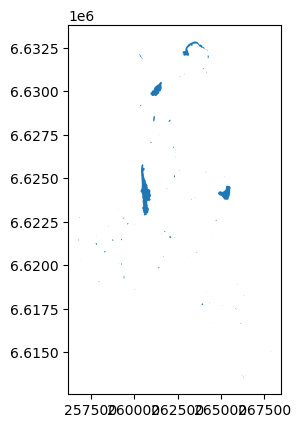

In [18]:
innsjoer.plot()

Og til slutt, skriv de filtrerte dataene til en Shapefile:

In [19]:
innsjoer.to_file(DATA_MAPPE / "arealdekke" / "innsjoer.gpkg")

Sjekk [Vector Data I/O](#03_vektor) avsnittet for å se hvilke dataformater
geopandas kan skrive til.

## Gruppering av data

En spesielt nyttig metode i (geo)pandas' dataframes er deres grupperingsfunksjon: [`groupby()`](https://pandas.pydata.org/docs/user_guide/groupby.html)
kan **dele data inn i grupper** basert på noen kriterier, **bruke** en funksjon
individuelt til hver av gruppene, og **kombinere** resultater av en slik
operasjon i en felles datastruktur.

Vi kan bruke *gruppering* her for å dele inputdatasettet vårt i delmengder som relatere
til hver av `klasse`ne i arealdekke, deretter lagre en separat fil for hver
klasse.

La oss starte dette ved igjen å ta en titt på hvordan datasettet faktisk ser ut:

In [20]:
data.head()

,klasse,klasse_navn,geometry,areal
0,100,myr,"POLYGON ((265791.900 6614994.650, 265790.180 6...",1955.48975
1,100,myr,"POLYGON ((262206.270 6628558.130, 262202.640 6...",1101.93145
2,100,myr,"POLYGON ((265299.880 6621504.120, 265294.080 6...",2657.99245
3,100,myr,"POLYGON ((260561.580 6622897.200, 260562.110 6...",6740.99175
4,100,myr,"POLYGON ((265326.090 6621350.040, 265320.020 6...",2715.09810


Husk: kolonnen `klasse` inneholder informasjon om en polygons arealbrukstype. Bruk metoden [`pandas.Series.unique()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html) for å liste alle verdier som forekommer:

In [21]:
data["klasse"].unique()

array([100, 200, 700, 600, 500, 400, 300, 800, 900, 110, 120])

For å gruppere data, bruk data-rammens `groupby()` metode, oppgi et kolonnenavn som parameter:

In [22]:
gruppert_data = data.groupby("klasse")
gruppert_data

Så, `gruppert_data` er et `DataFrameGroupBy` objekt. Inne i et `GroupBy` objekt,
er egenskapen `groups` en ordbok som fungerer som en oppslagstabell: den registrerer
hvilke rader som hører til hvilken gruppe. Nøklene i ordboken er de unike
verdiene av gruppekolonnen:

In [23]:
gruppert_data.groups

{100: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], 110: [1255, 1256], 120: [1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285], 200: [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101], 300: [775, 776, 777, 778, 779, 780, 781, 782, 783], 400: [773, 774], 500: [770, 771, 772], 600: [623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680

Imidlertid kan man også ganske enkelt iterere over hele `GroupBy` objektet. La oss
telle hvor mange rader med data hver gruppe har:

In [24]:
for key, group in gruppert_data:
    print(f"Arealdekkeklasse {key} har {len(group)} rader.")

Arealdekkeklasse 100 har 22 rader.
Arealdekkeklasse 110 har 2 rader.
Arealdekkeklasse 120 har 29 rader.
Arealdekkeklasse 200 har 80 rader.
Arealdekkeklasse 300 har 9 rader.
Arealdekkeklasse 400 har 2 rader.
Arealdekkeklasse 500 har 3 rader.
Arealdekkeklasse 600 har 147 rader.
Arealdekkeklasse 700 har 521 rader.
Arealdekkeklasse 800 har 458 rader.
Arealdekkeklasse 900 har 13 rader.


Det er for eksempel 80 innsjøpolygoner (klasse `200`) i inngangsdatasettet.

For å få alle rader som tilhører en bestemt gruppe, bruk `get_group()`
metoden, som returnerer en helt ny `GeoDataFrame`:

In [25]:
innsjøer = gruppert_data.get_group(200)
type(innsjøer)

geopandas.geodataframe.GeoDataFrame

```{caution}OBS
Indeksen i den nye data-frammen forblir den samme som i det ugrupperte inputdatasettet.
Dette kan være nyttig, for eksempel når du vil slå sammen de grupperte dataene
tilbake til de originale inputdataene.
```


## Skriv grupperte data til separate filer

Nå har vi alle nødvendige verktøy for hånden for å dele inputdataene i
separate datasett for hver arealdekkeklasse, og skrive de individuelle delmengdene til
nye, separate, filer. Faktisk ser koden nesten for enkel ut, gjør den ikke?

In [26]:
# Iterer over inngangsdataene, gruppert etter "klasse"
for key, group in data.groupby("klasse"):
    # lagre gruppen til en ny shapefile
    group.to_file(DATA_MAPPE / "arealdekke" / f"arealdekke_{key}.gpkg")

```{admonition} Filnavn
:class: attention

Vi brukte en `pathlib.Path` kombinert med en f-streng for å generere den nye output-filens sti og navn. Sjekk [Håndtering av filstier-notebooken](#03_filstier)
for å gå gjennom hvordan de fungerer.
```


## Ekstra: lagre sammendragsstatistikk til CSV regneark

Når resultatene av en operasjon på en `GeoDataFrame` ikke inkluderer en
geometri, vil data-rammen som kommer ut automatisk bli en 'vanlig'
`pandas.DataFrame`, og kan lagres til standard tabellformater.

En interessant anvendelse av dette er å lagre grunnleggende beskrivende statistikk av et geografisk datasett til en CSV-tabell. For eksempel ønsker vi kanskje å vite arealet hver arealdekkeklasse dekker.

Igjen starter vi med å gruppere inputdataene etter arealdekke, og deretter beregne summen av hver klasses areal. Dette kan kondenseres til en linje med kode:

In [27]:
areal_informasjon = data.groupby("klasse").areal.sum()
areal_informasjon

klasse
100    3.330440e+05
110    1.382096e+05
120    4.700334e+06
200    1.839231e+06
300    9.028421e+05
400    1.024443e+06
500    3.651047e+04
600    3.785512e+07
700    8.280398e+06
800    4.854529e+07
900    1.094627e+05
Name: areal, dtype: float64

Vi kan deretter lagre den resulterende tabellen til en CSV-fil ved å bruke  standard pandas tilnærming.

In [28]:
areal_informasjon.to_csv(DATA_MAPPE / "arealdekke" / "areal_per_arealdekkeklasse.csv")